In [1]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using dataPS
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [2]:
Eoff=5.0
Ts=collect(300.0:10.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[17.0e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e17]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.6]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])

effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTx,x::Float64)
    Da=7.0#9.0-1.5*x*x
    Dv=1.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTx(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTx(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTx(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTx(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandLH,bandX1],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2lowN_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2,tauPOP3

xmax=3.0

3.0

In [3]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 49.074381 seconds (232.80 M allocations: 42.997 GiB, 12.01% gc time)


3.0

In [4]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [5]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
function klpar(con::Float64,p::Float64,NP::Float64)
    thetaL=52.3e12*hbar/kB # K 
    thetaT=29.7e12*hbar/kB  # K
    vL=(1-con)*7700+con*4900    # m/s
    vT=(1-con)*4900+con*3000    # m/s
    gammaL=2.5*(1-con)+1.7*con
    gammaT=2.5*(1-con)+1.7*con
    M=(2*(24.305e-3)+(28.0855e-3*(1-con)+118.71e-3*con))/3/Nav
    V=((1-con)*(6.39e-10)^3+con*(6.77e-10)^3)/12
    a=V^(1.0/3.0)
    ro=M/V
    Vdj=(((6.39e-10)^3)/((1-con)*(6.39e-10)^3+con*(6.77e-10)^3))^(1/3)
    jL=vL/7700*Vdj
    jT=vT/4900*Vdj
    thetaLx=thetaL*jL
    thetaTx=thetaT*jT
    ##########Boundary Scattering###############3
    D=11e-9
    p=0.65
    ##########Alloy Scattering###################
    mbar=(28.0855*(1-con)+118.71*con)
    GammaSiSn=(1-con)*((28.0855-mbar)/mbar)^2+con*((118.71-mbar)/mbar)^2
    GammaMgSiSn=2*((mbar/(24.305+mbar))^2*GammaSiSn);         
    ##########Electron Scattering###################
    Ehp=1.0*q
    Eep=5.0*q
    xsp=xs[1]
    Tp=300.0
    mdx1=0.67*me
    mdx3=0.38*me
    mdLH=1.0*me
    mdHH=1.2*me
    Efx3=0.2589
    Efx1=0.2589
    ##########Nanoparticle Scattering###################
    #NP=0
    #alpha=1.0
    Rnp=1/2*15.0e-9#
    Vnp=4/3*pi*(Rnp)^3
    rhonp=NP/100/Vnp
    rhoM=3.0
    rhoT=3.78
    alphaNP=0.2289#1-exp(-1*(rhoT-rhoM)/rhoM);
#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
    Tsindex=1#25
    numberofnindex=1
    xsindex=1
    vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, con,#5
        thetaLx, thetaTx, thetaTx, M,   M, #10
        V, a, T_EF_Dict_Array, Eep, alphaNP, #15
        Rnp, thetaLx, thetaTx, vL, vT, #20
        vL, vT, p, NP,Tsindex,#25
        numberofnindex,xsindex,p,D,GammaMgSiSn,#30
        mdx1,mdx3,Efx1,Efx3,ro,#35,
        NP,alphaNP,Rnp,Vnp,rhonp, #40
        Ehp,mdHH,mdLH
        ]  
    thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
    thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
    #println("2")
    tauPHNLf(var)=tauPH_NL(var[3],var[11],var[1],var[2],var[9],var[21])
    tauPHNTf(var)=tauPH_NT(var[4],var[11],var[1],var[2],var[9],var[22]) 

    tauPHULf(var)=tauPH_U(var[3],var[1],var[2],var[9],var[19],var[17])
    tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],var[9],var[20],var[18])

    tauPHALLLf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[19])
    tauPHALLTf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[20])
   
    tauPHeLfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])


    tauPHeLfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[21])
    tauPHeTfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[22])

    tauPHBLf(var)=tauPH_B(var[19],var[28],var[29])
    tauPHBTf(var)=tauPH_B(var[20],var[28],var[29])
    #println("3")

    tauPHNPLf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[19])
    tauPHNPTf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[20])

    tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0)#,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPH_eLf ,tauPHALLLf ,tauPHBLf,,tauPHULf
    tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0) #tauPHeLfX3,tauPHeLfX1
    tauPHRL=tau_phonon_B([tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0) #,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPHALLLf,tauPH_eLf] ,tauPHBLf

    tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf
    tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf#

    tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf tauPHBTf
    tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTy=tau_phonon_B([tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPH_eTf ,tauPHBTf,tauPHALLTf,tauPHeTf
    #println("4")
    tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
    tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    tauPHTy=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    return (vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)
end
xmax=1.0

1.0

In [6]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.6,0.65,0.0)
klsM=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,klsM[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,
        tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(klsM[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [7]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.0,0.65,0.0)
kls0=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls0[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(kls0[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [8]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(1.0,0.5,0.0)
kls1=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls1[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
   # println("T=", iTx, " kl= " ,round(kls1[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [9]:
yaa=0.6
aMgSi=6.39e-10
aMgSn=6.77e-10
ks=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
klsT=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
f=0.65
for (iT,iTx) in enumerate(Ts)  
    klsT[iT,1,1]=(1-f)*klsM[iT,1,1]+f*(kls1[iT,1,1]*(1-yaa)aMgSn^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3)+kls0[iT,1,1]*(yaa)aMgSi^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3))
       ks[iT,1,1]=klsT[iT,1,1]+kes[iT,1,1]+kbis[iT,1,1,] 
    #println("T=", iTx, " kl= " ,round(klsT[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

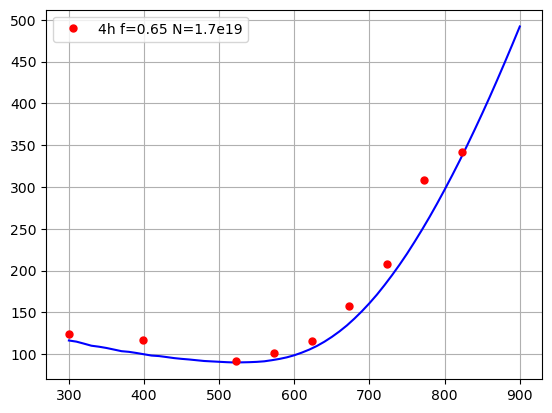

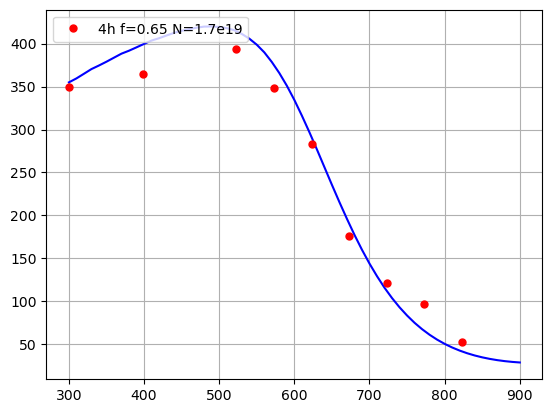

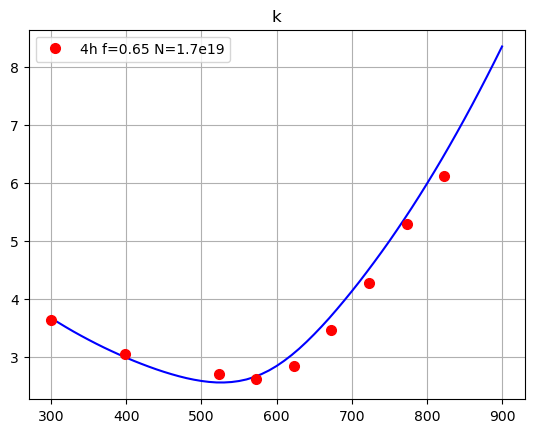

In [22]:
figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn4hECE,linestyle="None",marker=".",
    markersize=10,color="r",label=string("4h f=$f N=$(numofn[1])"))
legend(loc="upper left")
grid()
figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn4hSCS,linestyle="None",marker=".",
    markersize=10,color="r",label=string("4h f=$f N=$(numofn[1])"))
legend(loc="upper left")
grid()

figure()
title("k")
plot(Ts,klsT[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn4hKCK,linestyle="None",marker="o",
    markersize=7,color="r",label=string("4h f=$f N=$(numofn[1])"))

legend(loc="upper left")
#ylim(1.5,3.5)
grid()

In [11]:
Ts

61-element Array{Float64,1}:
 300.0
 310.0
 320.0
 330.0
 340.0
 350.0
 360.0
 370.0
 380.0
 390.0
 400.0
 410.0
 420.0
   ⋮
 790.0
 800.0
 810.0
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0

In [12]:
foreach(x->println(ks[x,1,1]),1:length(Ts))

3.674624455351219
3.59413923260106
3.5160898242929566
3.4408143286293726
3.3690917610580375
3.299872133361033
3.2330236764719564
3.1686658613088463
3.1076149365059793
3.0485809273408773
2.9918323855432885
2.937486806064563
2.886451838644377
2.837476152188745
2.7911420134971245
2.748055770366051
2.708411781490501
2.6720972547192927
2.6397712074658664
2.612622068916515
2.590655985527611
2.57453765816251
2.565217543570657
2.5646211896642073
2.572374134918385
2.5896167549700713
2.617303629756003
2.657826664067878
2.7093342641186635
2.7727623337523513
2.8489016191584486
2.9377476177257074
3.0370419961733672
3.1465347095555414
3.2668539829444647
3.3955251360135934
3.531082876944366
3.6730400894517192
3.82270830222943
3.976903934779025
4.135583411738853
4.29878496878364
4.46857170134734
4.6416913067247005
4.819052967980202
5.000933145143521
5.189592100773995
5.381709596095647
5.578542413771167
5.781193831910263
5.989206491197251
6.201827885742519
6.419518623843977
6.643494002201836
6.87246557

In [13]:
foreach(x->println(sigmas[x,1,1]),1:length(Ts))

11643.033113076226
11505.917221514243
11266.576540781642
11016.715402764314
10899.16156353203
10746.125345018916
10556.774606028193
10364.022049435316
10284.008124781007
10145.940682423468
9992.710657089765
9839.361660049844
9777.865708555582
9659.873690133063
9536.4596597312
9444.279744066918
9371.0763430767
9279.470947125306
9189.916267094119
9141.914731911178
9093.90169134119
9047.065767799802
9012.328324572332
9027.701474141624
9047.126913081574
9085.751127035468
9152.262257176666
9283.612542682584
9434.835923208782
9626.986945105728
9877.560877602034
10193.855715684287
10559.071934993786
10986.230970734709
11497.002465977408
12077.690704405393
12725.903956799904
13447.601761878923
14265.116671630469
15151.024067833261
16108.488849527104
17139.49139531632
18267.22768271991
19454.492001620092
20708.950617170085
22030.8962027857
23444.943797153715
24907.663044552253
26430.859603722318
28025.7223201823
29683.838597065012
31392.524549133508
33155.412008386236
34987.369557253725
36868.9

In [14]:
foreach(x->println(-seebecks[x,1,1]*1e6),1:length(Ts))

-354.8925219163253
-359.486761806433
-364.8969420061932
-370.3625105497501
-374.53255643646617
-378.9499151544038
-383.6501465212445
-388.32229431422405
-391.75350134207986
-395.68492457306814
-399.6792378698874
-403.56603510001173
-406.2936240311603
-409.47701027148713
-412.520962161843
-414.9519539044223
-416.84313827170416
-418.56881209536084
-419.8035828379363
-419.954218237033
-419.41365534116545
-418.04312669120196
-415.5676190309053
-411.3425777513862
-405.8362626552791
-398.73680951747804
-389.8469086016289
-378.62865898569703
-365.7411645126675
-351.0192545636024
-334.43877710495957
-316.21213999578083
-296.9414296492569
-276.88225437722616
-256.2345240776216
-235.61667448959986
-215.45126359935895
-196.01206435609836
-177.38539878481674
-160.00664568746043
-143.9538534689272
-129.26038294283453
-115.81212642172838
-103.77456149494455
-93.0296787682828
-83.48803866355098
-74.98600931793236
-67.56146025941638
-61.07393941969533
-55.40788124231346
-50.4966229251436
-46.276839616

In [15]:
foreach(x->println(kes[x,1,1]),1:length(Ts))

0.07187119900865845
0.07406560938867998
0.07559840509339404
0.07689701884417503
0.07883319139968654
0.08045156794562976
0.08171082985437812
0.08281182822797956
0.08462827588198596
0.08593013706317573
0.08701196201658858
0.08798836800867038
0.08967565723982922
0.09080026895085333
0.09179341488105298
0.09301024448584813
0.09435532062011438
0.09545383061165347
0.09650693678805114
0.09795022416363892
0.09934481283979353
0.1006988391971487
0.10213694671117586
0.10412410820497052
0.10611749574202188
0.1083010377651164
0.11078918039320633
0.11407583979414357
0.11758773201835962
0.12160971833111203
0.12639580008203863
0.13207096888862746
0.13842020860219845
0.1456484416528575
0.1541009510756693
0.16361178057040698
0.17417604283539467
0.18591773384443666
0.19922650056760183
0.21371770781187294
0.22947900613705752
0.24658304076924376
0.2654629527290747
0.28554442023512805
0.3069940812131384
0.32985753435413234
0.35461709521846463
0.38054473017513346
0.4078856568766478
0.4368865144136851
0.467434

In [16]:
foreach(x->println(kbis[x,1,1]),1:length(Ts))

7.584979895729397e-6
1.5773181983080172e-5
3.102947886409434e-5
5.852152659131353e-5
0.00010789384427557306
0.00019149860593411768
0.0003280435494287115
0.0005456541204022517
0.000895367245989471
0.001423751440003085
0.0022086115322509825
0.0033534278822378717
0.005046617779776818
0.007403741384103566
0.010665334884621049
0.015168191444501045
0.021283833690641903
0.02935220037341765
0.03990534597956052
0.05376670664944537
0.0714484195966037
0.09367081499605717
0.12132026802508228
0.1559148553846899
0.197677527783143
0.24761653977855616
0.30662119211473204
0.3766361306778557
0.45642731826183486
0.5466878041127725
0.6479941862979963
0.7602547773169595
0.8814621224854402
1.0111952710870349
1.1497694317099405
1.2949064902679812
1.4451750871036517
1.5999916790816975
1.7603043279235755
1.9233389623615686
2.0889880035906376
2.2572395366499824
2.429744927492102
2.6038465881981643
2.7803064980999856
2.9593740491421077
3.1428448664390642
3.328143617831042
3.516297980183959
3.708179984230418
3.90

In [17]:
foreach(x->println(klsT[x,1,1]),1:length(Ts))

3.602745671362665
3.5200578500303967
3.4404603897206982
3.3638587882586064
3.290150675814075
3.2192290668094694
3.1509848030681495
3.0853083789604647
3.0220912933780038
2.9612270388376984
2.902611811994449
2.8461450101736547
2.791729563624771
2.739272141853788
2.6886832637314506
2.6398773344357016
2.592772627179745
2.547291223734222
2.5033589246982544
2.4609051381034313
2.4198627530912136
2.3801680039693043
2.3417603288343987
2.304582226074547
2.26857911139322
2.2336991774263986
2.199893257248065
2.1671146935958787
2.135319213838469
2.1044648113084667
2.074511632778414
2.0454218715201207
2.017159665085728
1.9896909968156489
1.9629836001588552
1.9370068651752048
1.9117317470053194
1.887130676525585
1.8631774737382527
1.839847264605583
1.8171164020111585
1.7949623913644144
1.7733638211261638
1.7523002982914084
1.7317523886670778
1.7117015616472808
1.6921301391164651
1.6730212480894715
1.6543587767105608
1.6361273332661599
1.618312207907083
1.6008993368176416
1.5838752686075135
1.56722713